In [1]:
import numpy as np
import larcv 
import h5py
import matplotlib.pyplot as plt

In [2]:
# Create the config builder and turn verbosity down low:
from larcv.config_builder import ConfigBuilder
cb = ConfigBuilder()
cb.set_parameter(["/home/giorgio/merged_sample_0.h5"], "InputFiles") # Pass input files as a list because you can combine them here
cb.set_parameter(5, "ProcessDriver", "IOManager", "Verbosity")
cb.set_parameter(5, "ProcessDriver", "Verbosity")
cb.set_parameter(5, "Verbosity")

In [3]:
name = "demo"

cb.add_batch_filler(
    datatype  = "sparse2d",
    producer  = "dunevoxels",
    name      = name+"data", 
    MaxVoxels = 2000, 
    Augment   = False, 
    Channels  = [0,] 
)

cb.add_batch_filler(
    datatype  = "particle",
    producer  = "",
    name      = name+"label",
)

# Build up the data_keys:
data_keys = {
    'image': name + 'data',
    'label': name + 'label'
    }

import json
print(json.dumps(cb.get_config(), indent=2))

{
  "InputFiles": [
    "/home/giorgio/merged_sample_0.h5"
  ],
  "ProcessDriver": {
    "EnableFilter": false,
    "IOManager": {
      "IOMode": 0,
      "Input": {
        "InputFiles": [],
        "ReadOnlyName": [],
        "ReadOnlyType": [],
        "UseH5CoreDriver": false
      },
      "Output": {
        "Compression": 1,
        "OutFileName": "",
        "StoreOnlyName": [],
        "StoreOnlyType": []
      },
      "Verbosity": 5
    },
    "NumEntries": 0,
    "ProcessList": {
      "demodata": {
        "Augment": false,
        "Channels": [
          0
        ],
        "IncludeValues": true,
        "MaxVoxels": 2000,
        "Producer": "dunevoxels",
        "UnfilledVoxelValue": -999.0
      },
      "demolabel": {
        "MaxParticles": 30,
        "Producer": "segment"
      }
    },
    "ProcessName": [
      "demodata",
      "demolabel"
    ],
    "ProcessType": [
      "BatchFillerSparseTensor2D",
      "BatchFillerParticle"
    ],
    "RandomAccess": fals

In [4]:
from larcv.queueloader import queue_interface
# from larcv.distributed_queue_interface import queue_interface # This is the multi-node, parallel version!

queue_interface = queue_interface(random_access_mode="random_blocks", seed=1234)
queue_interface.no_warnings()

# This gets the queue interface started:
batch_size=1


# Prepare data managers: (You can have more than one!  Train / test / anything)
io_config = {
    'filler_name' : name,
    'filler_cfg'  : cb.get_config(),
    'verbosity'   : 5,
    'make_copy'   : False # This is if you want to make a copy of data in python
}


queue_interface.prepare_manager(name, io_config, batch_size, data_keys, color=None)

In [5]:
data_dict = queue_interface.fetch_minibatch_data(name, pop=True,fetch_meta_data=True)

In [6]:
print(data_dict.keys())

dict_keys(['image', 'label', 'entries', 'event_ids'])


In [7]:
# Print the image of this data:
print(data_dict["image"].shape)
for i in range(5):
    print(data_dict['image'][0,0,i])


(1, 1, 2000, 3)
[176.        201.          1.6312013]
[177.        201.          1.0095792]
[178.        201.          0.6894916]
[178.        202.          1.5858864]
[179.        201.          1.0525091]


In [8]:
point_cloud = data_dict["image"][0, 0]
img = np.zeros((2000,2000))
for point in point_cloud:
    x, y, val = point
    # print(int(x), int(y), val)
    if x >= 0 and y >=0:
        img[int(x-1)][int(y-1)] = val
        # print(x, y, val)
print((img>2.5).sum())

22


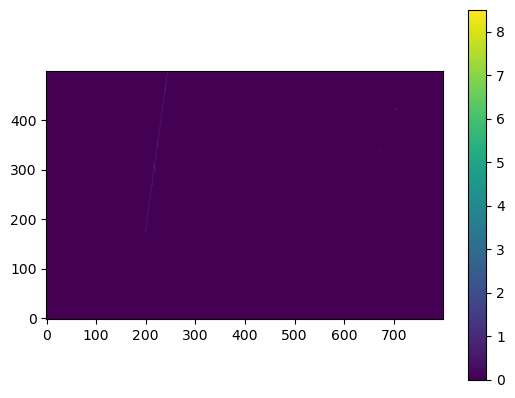

In [9]:
plt.imshow(img[:500, :800], origin=("lower"),)
plt.colorbar()

In [10]:
queue_interface.prepare_next(name) # prepare more data for the dataset tagged with `name`

In [11]:
re_data_dict = queue_interface.fetch_minibatch_data(name, pop=False,fetch_meta_data=True)
print(re_data_dict["label"]["_pdg"])

[[        13       2112       2212 1000180400       2112       2112
        2212       2112       2112       2212       2212       2112
        2112       2112       2212       2112         22         22
        2112         22 1000140280         22       2112         22
          22         22 1000180400 1000180400 1000180400 1000070140]]


In [12]:
# Calling with pop = True will discard this data after you use it - so you get it one more time,
# but the next time is different.  In general, you usually want pop = True.
re_data_dict = queue_interface.fetch_minibatch_data(name, pop=True,fetch_meta_data=True)
queue_interface.prepare_next(name)
print(re_data_dict['label']["_pdg"])

[[        14       3122        321       2112       -211        -14
          13         22       2112       2112 1000180390        130
        2212       2212       2112       2112       2212         22
        2112       2112         22         22 1000020040 1000140290
  1000180400       2212         22       2112       2112         22]]


In [13]:
re_data_dict = queue_interface.fetch_minibatch_data(name, pop=True,fetch_meta_data=True)
queue_interface.prepare_next(name)
print(re_data_dict['label']["_pdg"])

[[        14       2212       2112       2212       2212       2212
        2112       2212       2112       2112         22 1000150330
  1000180400 1000180400         22       2112         22 1000180400
  1000180400 1000180400 1000180400 1000180400 1000180400 1000180400
  1000180400 1000180400       2112         22         22 1000180400]]


In [14]:
re_data_dict = queue_interface.fetch_minibatch_data(name, pop=True,fetch_meta_data=True)
queue_interface.prepare_next(name)

point_cloud = re_data_dict["image"][0, 0]
img = np.zeros((2000,2000))
for point in point_cloud:
    x, y, val = point
    # print(int(x), int(y), val)
    if x >= 0 and y >=0:
        img[int(x-1)][int(y-1)] = val
        # print(x, y, val)
print((img>2.5).sum())
print(re_data_dict["label"]["_ancestor_pdg"])
print(re_data_dict["label"]["_pdg"])
print(re_data_dict["label"]["_parent_pdg"])


86
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[        14       2112       2112        111        111       2112
         111         22         22       2112       2212       2112
          22       2112         22       2112       2112 1000170350
          22         22         22         22 1000180400 1000180400
  1000180400 1000180400 1000180400 1000180400 1000180400 1000180400]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


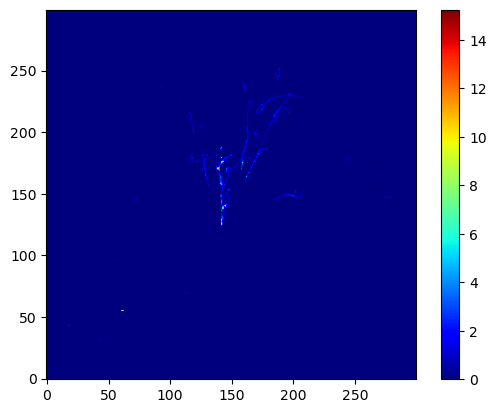

In [15]:
plt.imshow(img[1150:1450, 100:400], origin=("lower"), cmap=("jet"))
plt.colorbar()

In [16]:
re_data_dict = queue_interface.fetch_minibatch_data(name, pop=True,fetch_meta_data=True)
queue_interface.prepare_next(name)

point_cloud = re_data_dict["image"][0, 0]
img = np.zeros((2000,2000))
for point in point_cloud:
    x, y, val = point
    # print(int(x), int(y), val)
    if x >= 0 and y >=0:
        img[int(x-1)][int(y-1)] = val
        # print(x, y, val)
print((img>2.5).sum())
print(re_data_dict["label"]["_ancestor_pdg"])
print(re_data_dict["label"]["_pdg"])
print(re_data_dict["label"]["_parent_pdg"])

186
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[       -11       2212       -211       -211       2212       2212
        2112       2112       2112         22       2112         22
  1000160350       2112       -211        211       -211       2212
          22       2112       2112       2112       2212       2112
        2112         22       2112         22 1000010020 1000010020]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


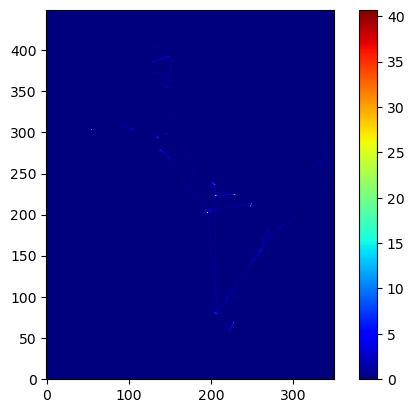

In [17]:
plt.imshow(img[150:600, 400:750], origin=("lower"), cmap=("jet"))
plt.colorbar()

In [18]:
re_data_dict = queue_interface.fetch_minibatch_data(name, pop=True,fetch_meta_data=True)
queue_interface.prepare_next(name)

point_cloud = re_data_dict["image"][0, 0]
img = np.zeros((2000,2000))
for point in point_cloud:
    x, y, val = point
    # print(int(x), int(y), val)
    if x >= 0 and y >=0:
        img[int(x-1)][int(y-1)] = val
        # print(x, y, val)
print((img>2.5).sum())
print(re_data_dict["label"]["_ancestor_pdg"])
print(re_data_dict["label"]["_pdg"])
print(re_data_dict["label"]["_parent_pdg"])

38
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[       -14       2112       2212        111       2112         22
        2112         22         22 1000180400         22         22
        2112       2112       2212       2112       2112         22
        2212       2212       2112         22 1000150330         22
          22       2112 1000180400         22       2112         22]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


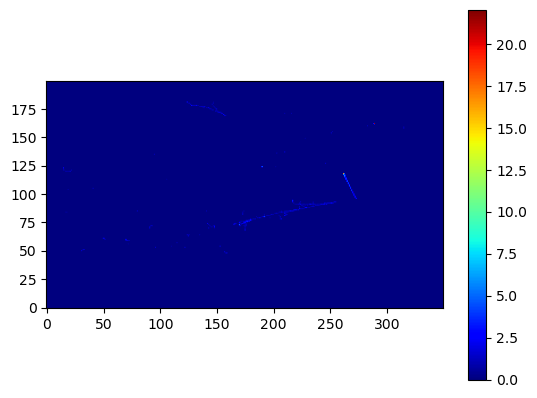

In [19]:
plt.imshow(img[1050:1250, 400:750], origin=("lower"), cmap=("jet"))
plt.colorbar()